In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import joblib
import warnings
import mlflow
from pathlib import Path

%matplotlib inline
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

In [2]:
import sys
from pathlib import Path

project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

## Load Data and Model
load the processed training data to analyze feature importance and the trained model.

In [ ]:
# Load the processed training data
test_df = pd.read_csv("test_features.csv")
print(f"Test data shape: {test_df.shape}")
test_df.head()

Test data shape: (2093, 23)


,Airline,Source,Destination,Duration,Total_Stops,Price,duration__Duration,doj__Date_of_Journey_month,doj__Date_of_Journey_day_of_week,doj__Date_of_Journey_day_of_month,...,arr_time__Arrival_Time_minute,addition_info__Additional_Info_1 Long layover,addition_info__Additional_Info_1 Short layover,addition_info__Additional_Info_2 Long layover,addition_info__Additional_Info_Business class,addition_info__Additional_Info_Change airports,addition_info__Additional_Info_In-flight meal not included,addition_info__Additional_Info_No check-in baggage included,addition_info__Additional_Info_No info,addition_info__Additional_Info_Red-eye flight
0,11599.021081,8022.872877,12007.421225,1455,1,17996,0.507881,0.000000,0.333333,0.192308,...,0.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4335.841718,9143.083566,9143.083566,140,0,3873,0.047285,1.000000,0.500000,0.192308,...,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5668.469897,9143.083566,9143.083566,170,0,4462,0.057793,0.000000,0.000000,0.653846,...,0.363636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,11599.021081,5059.708752,5059.708752,90,0,2228,0.029772,0.000000,1.000000,0.884615,...,0.363636,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4335.841718,8022.872877,5143.918577,170,0,4991,0.057793,0.333333,0.833333,1.000000,...,0.363636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
X = test_df.drop(["Price"], axis=1)
y = test_df["Price"]

print("Features available for analysis:")
print(X.columns.tolist())
X.describe()

Features available for analysis:
['Airline', 'Source', 'Destination', 'Duration', 'Total_Stops', 'duration__Duration', 'doj__Date_of_Journey_month', 'doj__Date_of_Journey_day_of_week', 'doj__Date_of_Journey_day_of_month', 'dep_time__Dep_Time_hour', 'dep_time__Dep_Time_minute', 'arr_time__Arrival_Time_hour', 'arr_time__Arrival_Time_minute', 'addition_info__Additional_Info_1 Long layover', 'addition_info__Additional_Info_1 Short layover', 'addition_info__Additional_Info_2 Long layover', 'addition_info__Additional_Info_Business class', 'addition_info__Additional_Info_Change airports', 'addition_info__Additional_Info_In-flight meal not included', 'addition_info__Additional_Info_No check-in baggage included', 'addition_info__Additional_Info_No info', 'addition_info__Additional_Info_Red-eye flight']


,Airline,Source,Destination,Duration,Total_Stops,duration__Duration,doj__Date_of_Journey_month,doj__Date_of_Journey_day_of_week,doj__Date_of_Journey_day_of_month,dep_time__Dep_Time_hour,...,arr_time__Arrival_Time_minute,addition_info__Additional_Info_1 Long layover,addition_info__Additional_Info_1 Short layover,addition_info__Additional_Info_2 Long layover,addition_info__Additional_Info_Business class,addition_info__Additional_Info_Change airports,addition_info__Additional_Info_In-flight meal not included,addition_info__Additional_Info_No check-in baggage included,addition_info__Additional_Info_No info,addition_info__Additional_Info_Red-eye flight
count,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,...,2093.000000,2093.000000,2093.0,2093.0,2093.0,2093.000000,2093.000000,2093.000000,2093.000000,2093.0
mean,8995.847734,9047.542884,9018.300384,625.802676,0.789775,0.217444,0.569677,0.495620,0.476919,0.543676,...,0.447118,0.001911,0.0,0.0,0.0,0.000956,0.189202,0.035356,0.772575,0.0
std,2708.359977,1646.442353,2279.057607,502.256524,0.659357,0.175922,0.391364,0.332926,0.329673,0.248802,...,0.301439,0.043685,0.0,0.0,0.0,0.030905,0.391763,0.184722,0.419269,0.0
min,4335.841718,4789.892388,4789.892388,75.000000,0.000000,0.024518,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,5668.469897,8022.872877,9143.083566,170.000000,0.000000,0.057793,0.000000,0.333333,0.192308,0.347826,...,0.181818,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0
50%,9556.608028,9143.083566,10461.600690,490.000000,1.000000,0.169877,0.666667,0.500000,0.423077,0.478261,...,0.454545,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0
75%,11599.021081,10461.600690,10461.600690,895.000000,1.000000,0.311734,1.000000,0.833333,0.769231,0.739130,...,0.636364,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.0
max,11599.021081,10461.600690,12007.421225,2565.000000,4.000000,0.896673,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0


In [ ]:
model_path = Path("best_model")
model = joblib.load(model_path)

## Feature Importance Analysis

Let's first look at the built-in feature importance from XGBoost before diving into SHAP analysis.

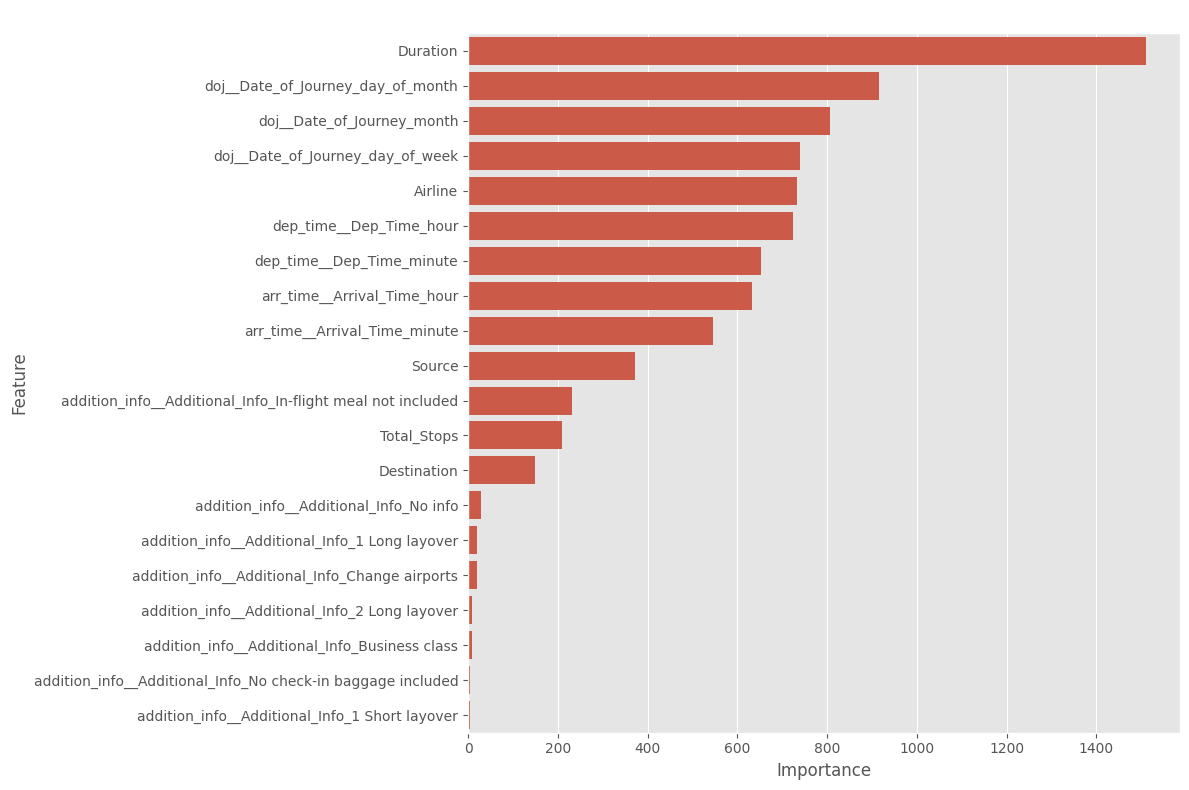

In [6]:
try:
    importance = model.get_booster().get_score(importance_type="weight")
except:
    raise ValueError("Model not loaded from joblib")

importance_df = pd.DataFrame(
    {"Feature": list(importance.keys()), "Importance": list(importance.values())}
).sort_values("Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("XGBoost Feature Importance (Weight)")
plt.tight_layout()
plt.show()

## SHAP Analysis

In [7]:
explainer = shap.Explainer(model)

sample_size = min(1000, len(X))
X_sample = X.sample(sample_size, random_state=42)
shap_values = explainer(X_sample)

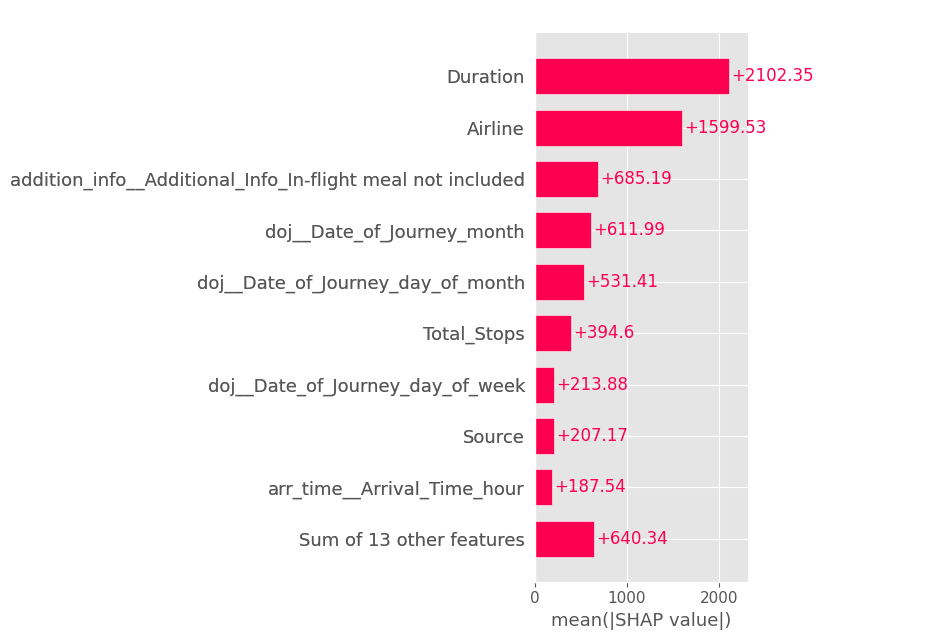

In [8]:
# SHAP Summary Plot (Bar)
plt.figure(figsize=(12, 8))
shap.plots.bar(shap_values, show=False)
plt.title("SHAP Feature Importance (Mean Absolute SHAP Values)")
plt.tight_layout()
plt.show()

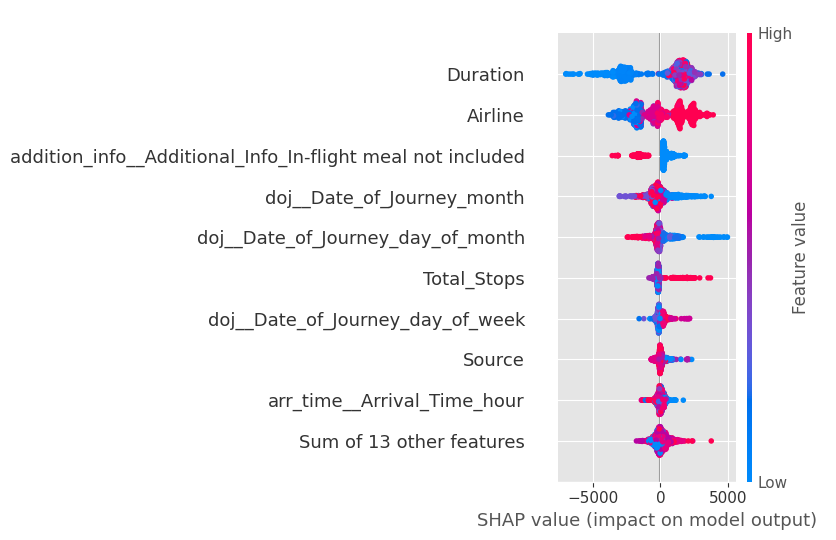

In [9]:
# SHAP Summary Plot (Beeswarm)
plt.figure(figsize=(12, 10))
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Feature Impact on Predictions")
plt.tight_layout()
plt.show()

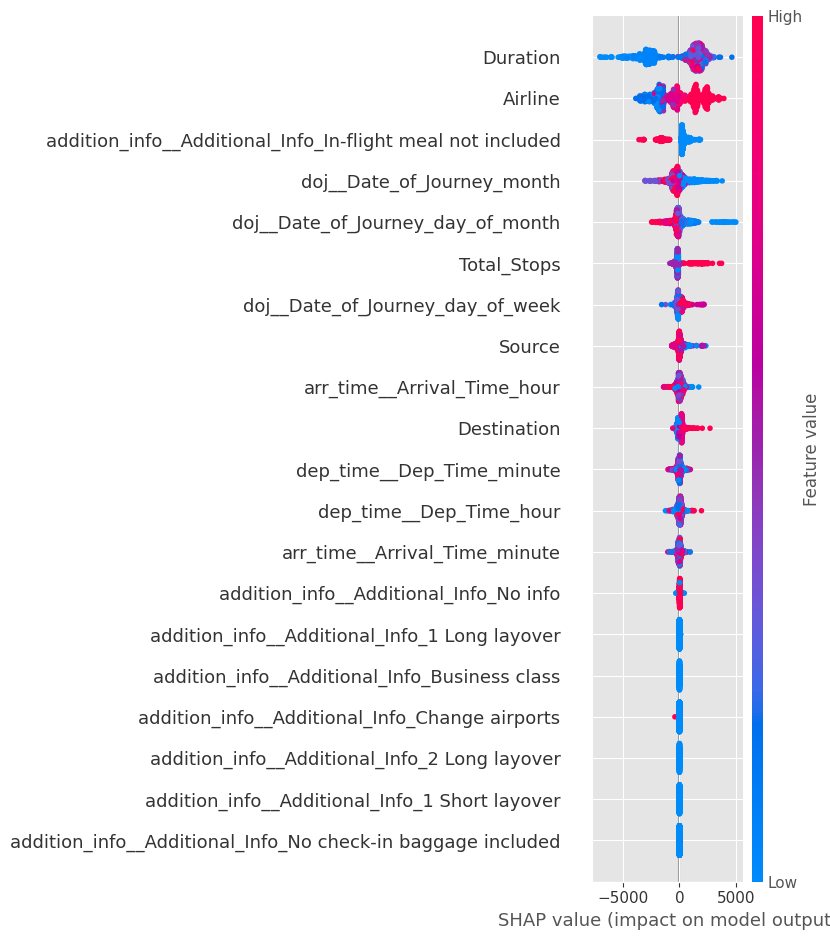

In [10]:
shap.summary_plot(shap_values)

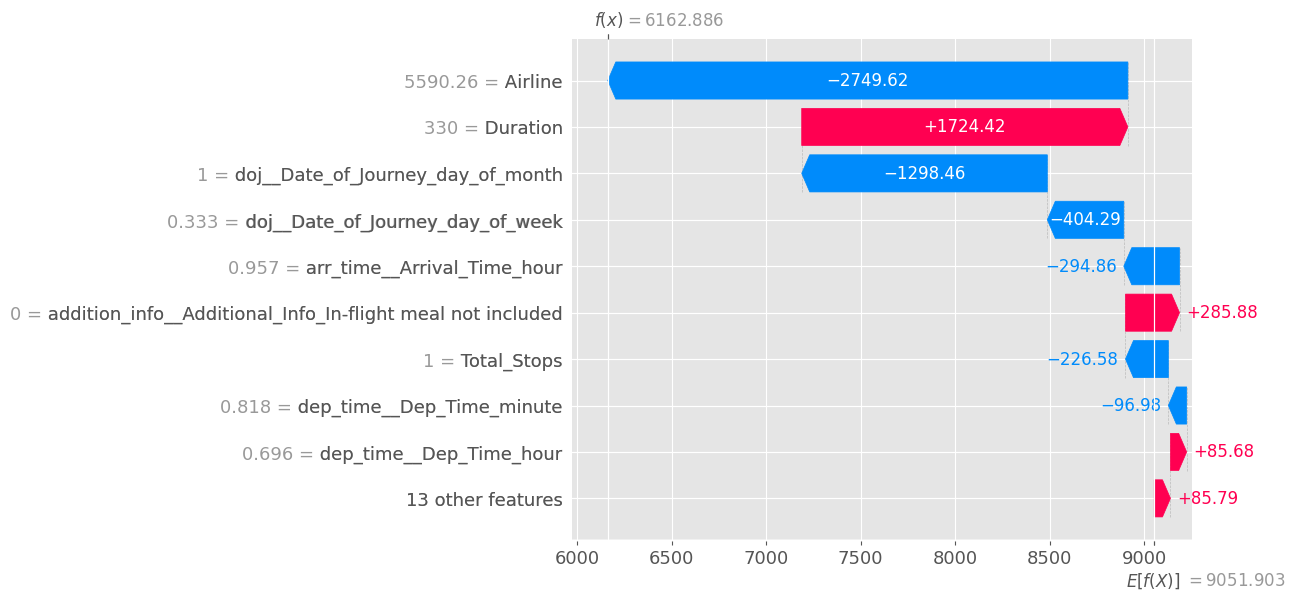

In [13]:
shap.waterfall_plot(shap_values[0])

<Figure size 1000x600 with 0 Axes>

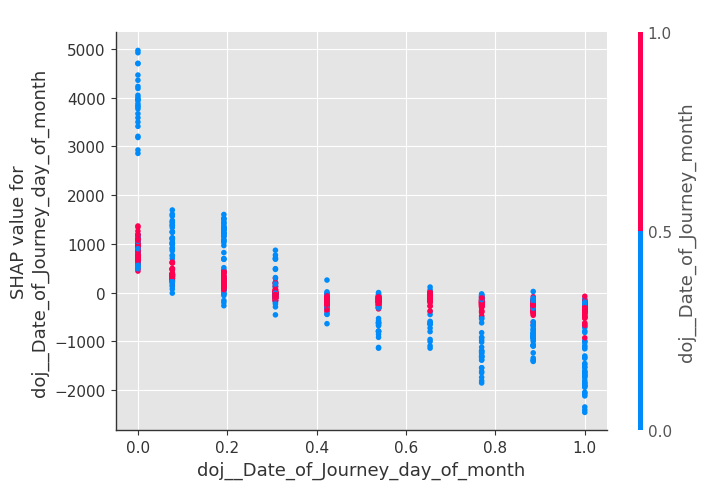

<Figure size 1000x600 with 0 Axes>

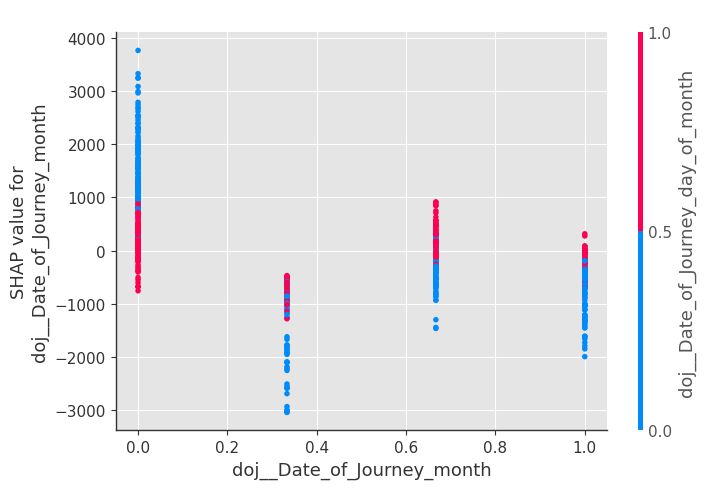

<Figure size 1000x600 with 0 Axes>

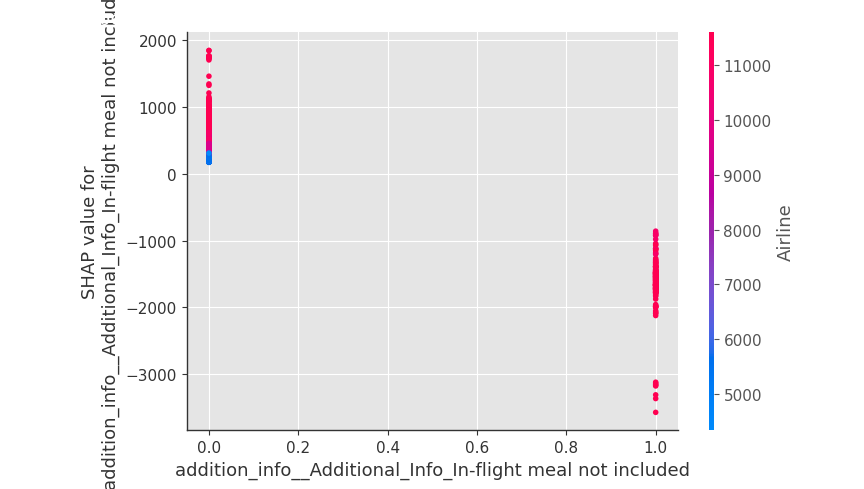

<Figure size 1000x600 with 0 Axes>

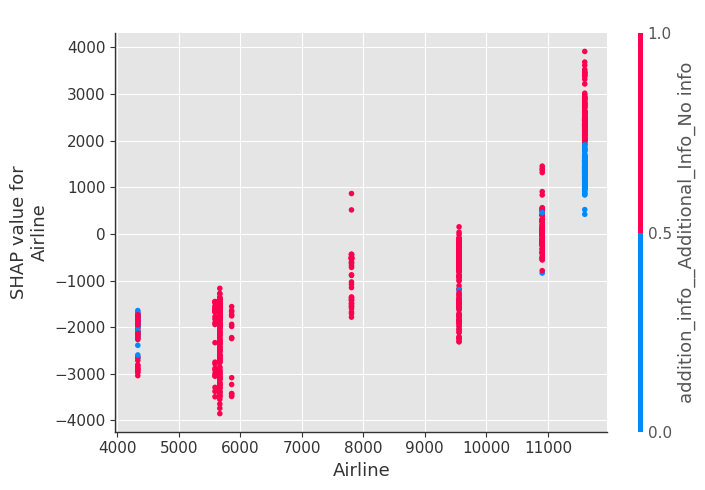

<Figure size 1000x600 with 0 Axes>

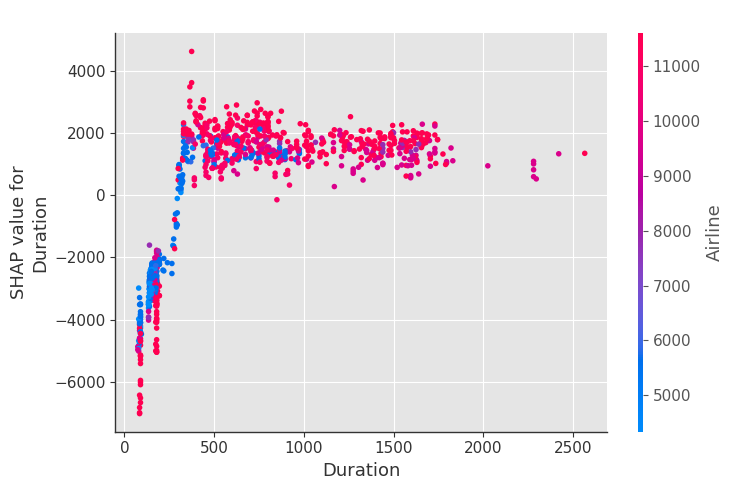

In [ ]:
# Get top 5 features by importance
top_features = shap_values.abs.mean(0).values.argsort()[-5:]
top_feature_names = X.columns[top_features].tolist()

for feature in top_feature_names:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature, shap_values.values, X_sample, show=False)
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()

Record #2062
Actual Price: $14053
Predicted Price: $13984.95
Difference: $68.05


<Figure size 2000x300 with 0 Axes>

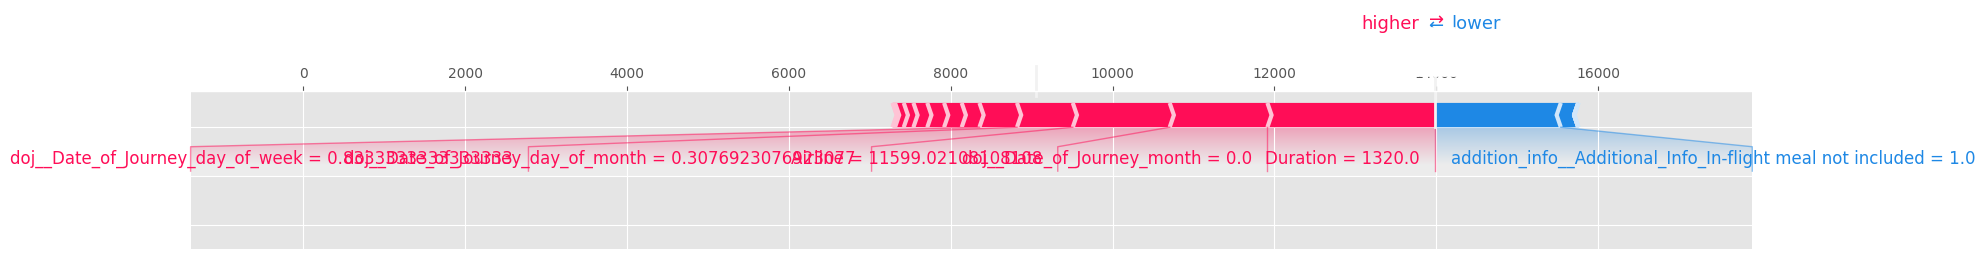


--------------------------------------------------------------------------------

Record #83
Actual Price: $10262
Predicted Price: $10936.79
Difference: $-674.79


<Figure size 2000x300 with 0 Axes>

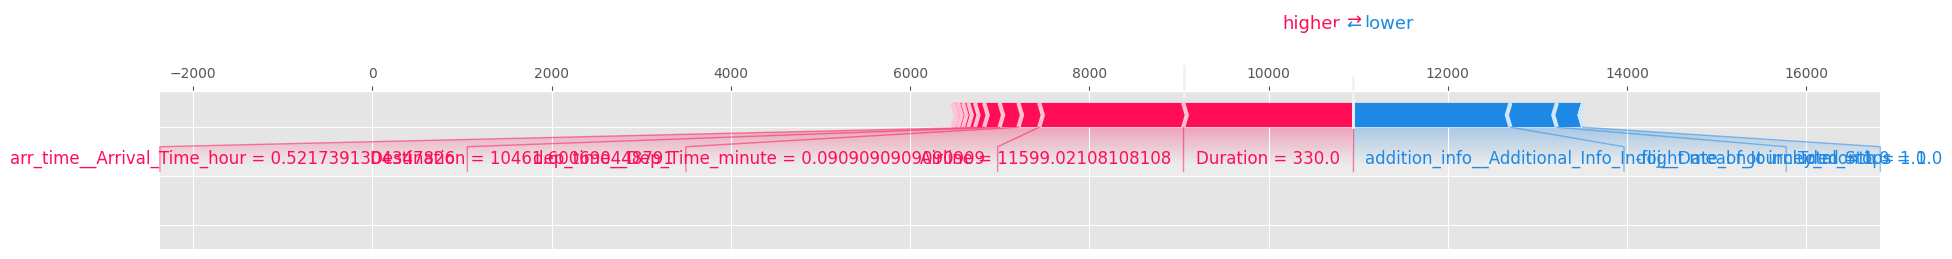


--------------------------------------------------------------------------------

Record #1457
Actual Price: $11848
Predicted Price: $13500.35
Difference: $-1652.35


<Figure size 2000x300 with 0 Axes>

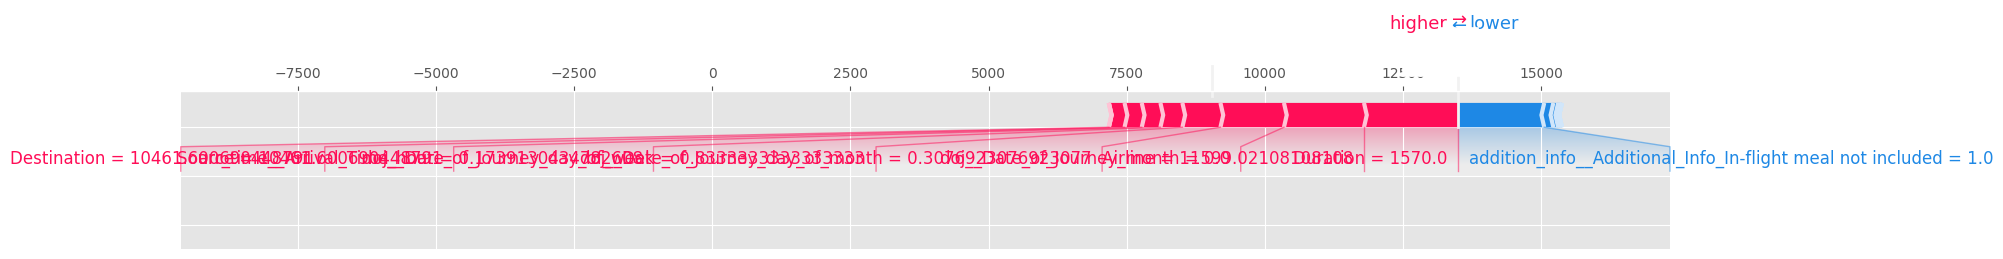


--------------------------------------------------------------------------------

Record #682
Actual Price: $13941
Predicted Price: $14103.43
Difference: $-162.43


<Figure size 2000x300 with 0 Axes>

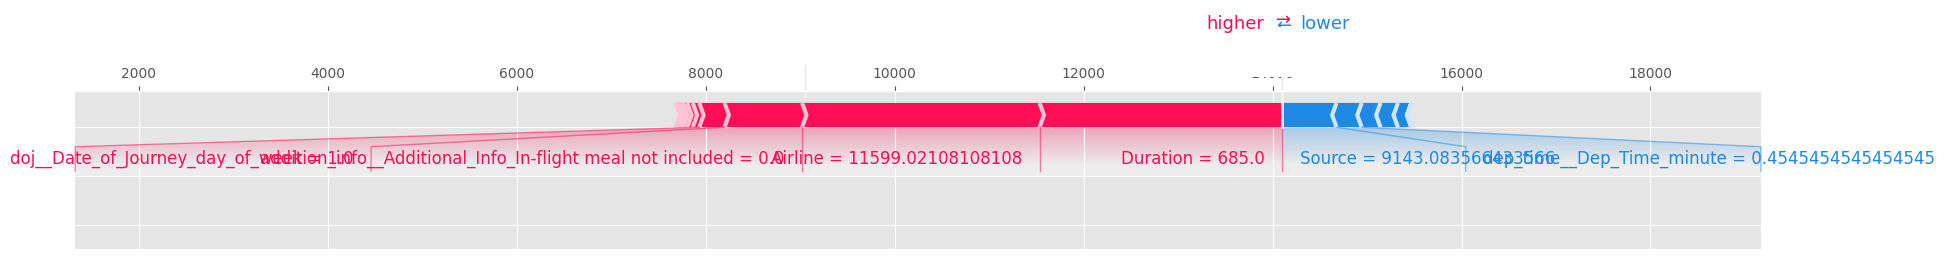


--------------------------------------------------------------------------------

Record #78
Actual Price: $15113
Predicted Price: $15111.57
Difference: $1.43


<Figure size 2000x300 with 0 Axes>

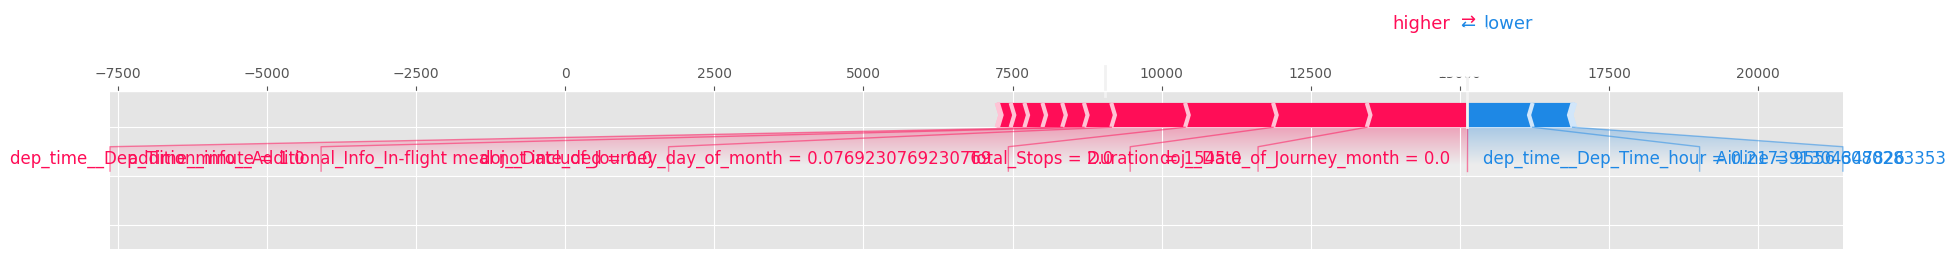


--------------------------------------------------------------------------------



In [144]:
sample_indices = np.random.choice(X_sample.index, 5, replace=False)

for idx in sample_indices:
    actual_price = y.loc[idx]
    predicted_price = model.predict(X.loc[[idx]])[0]

    print(f"Record #{idx}")
    print(f"Actual Price: ${actual_price}")
    print(f"Predicted Price: ${predicted_price:.2f}")
    print(f"Difference: ${actual_price - predicted_price:.2f}")

    plt.figure(figsize=(20, 3))
    shap_idx = X_sample.index.get_loc(idx) if idx in X_sample.index else 0
    shap.plots.force(shap_values[shap_idx], matplotlib=True, show=False)
    plt.title(f"SHAP Force Plot for Record #{idx}")
    plt.tight_layout()
    plt.show()
    print("\n" + "-" * 80 + "\n")

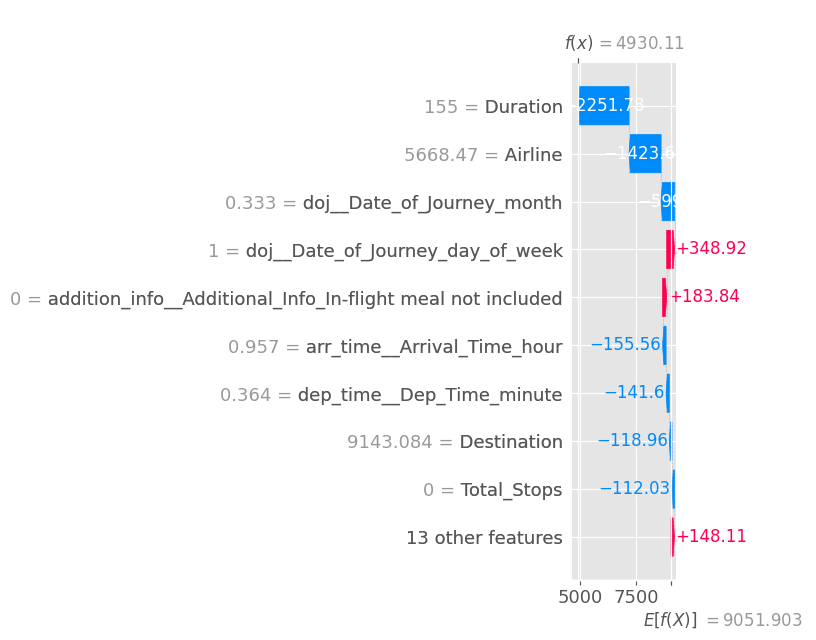

In [145]:
# Generate a waterfall plot for a specific instance
sample_idx = np.random.choice(X_sample.index)
plt.figure(figsize=(12, 8))
shap_idx = X_sample.index.get_loc(sample_idx) if sample_idx in X_sample.index else 0
shap.plots.waterfall(shap_values[shap_idx], show=False)
plt.title(f"SHAP Waterfall Plot for Record #{sample_idx}")
plt.tight_layout()
plt.show()

In [146]:
# Get mean absolute SHAP values for each feature
mean_abs_shap = pd.DataFrame(
    {"Feature": X_sample.columns, "SHAP_Importance": np.abs(shap_values.values).mean(0)}
).sort_values("SHAP_Importance", ascending=False)

# Get mean SHAP values (shows direction of impact)
mean_shap = pd.DataFrame(
    {"Feature": X_sample.columns, "Mean_SHAP_Value": shap_values.values.mean(0)}
)

# Merge the two
shap_summary = mean_abs_shap.merge(mean_shap, on="Feature")
shap_summary["Impact_Direction"] = shap_summary["Mean_SHAP_Value"].apply(
    lambda x: "Increases Price" if x > 0 else "Decreases Price"
)

# Display top 15 features
shap_summary

,Feature,SHAP_Importance,Mean_SHAP_Value,Impact_Direction
0,Duration,2102.346191,-60.306282,Decreases Price
1,Airline,1599.533325,-182.529877,Decreases Price
2,addition_info__Additional_Info_In-flight meal ...,685.191467,42.628281,Increases Price
3,doj__Date_of_Journey_month,611.992615,-61.867863,Decreases Price
4,doj__Date_of_Journey_day_of_month,531.405090,35.142372,Increases Price
5,Total_Stops,394.598785,12.810211,Increases Price
6,doj__Date_of_Journey_day_of_week,213.879089,52.310547,Increases Price
7,Source,207.174850,55.579269,Increases Price
8,arr_time__Arrival_Time_hour,187.542389,14.663190,Increases Price
9,Destination,181.461334,72.225739,Increases Price
